In [1]:
import sys
import time
from wideboost.wrappers import wxgb
import numpy as np
import xgboost as xgb

import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

for i in ds_train.batch(60000):
    a = i
    
for i in ds_test.batch(60000):
    b = i

In [7]:
xtrain = a[0].numpy().reshape([-1,28*28])
ytrain = a[1].numpy()

xtest = b[0].numpy().reshape([-1,28*28])
ytest = b[1].numpy()

In [8]:
def _onehot(Y):
    b = np.zeros((Y.shape[0], Y.max().astype(int)+1))
    b[np.arange(Y.shape[0]),Y.astype(int).flatten()] = 1
    return b

In [9]:
# subset for speed
def get_data(seed):
    np.random.seed(seed)
    train_idx = np.random.choice(range(xtrain.shape[0]), round(xtrain.shape[0] * 0.7), replace=False)
    valid_idx = np.array(list(set(range(xtrain.shape[0])) - set(train_idx)))
    train_idx = np.random.choice(train_idx, 3_000, replace=False)
    valid_idx = np.random.choice(valid_idx, 2_000, replace=False)

    test_idx = np.random.choice(range(xtest.shape[0]), 1_000, replace=False)

    features = np.random.choice(range(xtrain.shape[1]), 200, replace=False)


    y_train = _onehot(ytrain[train_idx])
    y_valid = _onehot(ytrain[valid_idx])
    y_test =  _onehot(ytest[test_idx])

    return (
        xtrain[train_idx[:,None], features],
        xtrain[valid_idx[:,None], features],
        xtest[test_idx[:,None], features], y_train, y_valid, y_test
    )

In [10]:
x_train, x_valid, x_test, y_train, y_valid, y_test = get_data(10101)

In [25]:
clf = xgb.XGBClassifier(
    n_estimators=200,
    eta=0.1,
    eval_metric='logloss'
)
clf.fit(x_train, y_train, verbose=10, eval_set=[
    (x_train, y_train),
    (x_test, y_test),
    (x_valid, y_valid)
])


[0]	validation_0-logloss:0.60945	validation_1-logloss:0.61323	validation_2-logloss:0.61270
[10]	validation_0-logloss:0.22478	validation_1-logloss:0.25102	validation_2-logloss:0.24946
[20]	validation_0-logloss:0.10423	validation_1-logloss:0.14178	validation_2-logloss:0.14176
[30]	validation_0-logloss:0.05604	validation_1-logloss:0.09851	validation_2-logloss:0.09957
[40]	validation_0-logloss:0.03410	validation_1-logloss:0.08018	validation_2-logloss:0.08157
[50]	validation_0-logloss:0.02287	validation_1-logloss:0.07165	validation_2-logloss:0.07293
[60]	validation_0-logloss:0.01642	validation_1-logloss:0.06727	validation_2-logloss:0.06818
[70]	validation_0-logloss:0.01243	validation_1-logloss:0.06485	validation_2-logloss:0.06546
[80]	validation_0-logloss:0.00975	validation_1-logloss:0.06300	validation_2-logloss:0.06362
[90]	validation_0-logloss:0.00793	validation_1-logloss:0.06219	validation_2-logloss:0.06247
[100]	validation_0-logloss:0.00665	validation_1-logloss:0.06145	validation_2-logl

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [13]:
watchlist = [
    ((x_train, y_train),'train'),
    ((x_test, y_test), 'test'),
    ((x_valid, y_valid), 'valid')
]

param = {
    'btype': 'I',
    'beta_eta': 0,
    'extra_dims': 0,
    'eval_metric': 'many_logloss',
    'eta': 0.1,
    'objective': 'manybinary:logistic',
    'output_dim': 10
}
xgb_results = {}
num_round = 100
wxgb.fit(
            x_train, y_train,
            param, num_round, watchlist,
            evals_result=xgb_results,
            verbose_eval=10
        )

[0]	train-many_logloss:0.60945	test-many_logloss:0.61323	valid-many_logloss:0.61270
[10]	train-many_logloss:0.22478	test-many_logloss:0.25102	valid-many_logloss:0.24946
[20]	train-many_logloss:0.10423	test-many_logloss:0.14178	valid-many_logloss:0.14175
[30]	train-many_logloss:0.05604	test-many_logloss:0.09851	valid-many_logloss:0.09957
[40]	train-many_logloss:0.03410	test-many_logloss:0.08018	valid-many_logloss:0.08157
[50]	train-many_logloss:0.02286	test-many_logloss:0.07165	valid-many_logloss:0.07293
[60]	train-many_logloss:0.01642	test-many_logloss:0.06727	valid-many_logloss:0.06818
[70]	train-many_logloss:0.01243	test-many_logloss:0.06485	valid-many_logloss:0.06546
[80]	train-many_logloss:0.00975	test-many_logloss:0.06300	valid-many_logloss:0.06362
[90]	train-many_logloss:0.00793	test-many_logloss:0.06219	valid-many_logloss:0.06247
[99]	train-many_logloss:0.00677	test-many_logloss:0.06149	valid-many_logloss:0.06186


In [40]:
watchlist = [
    ((x_train, y_train),'train'),
    ((x_test, y_test), 'test'),
    ((x_valid, y_valid), 'valid')
]

param = {
    'btype': 'I',
    'beta_eta': 0.01,
    'extra_dims': 10,
    'eval_metric': 'many_logloss',
    'eta': 0.1,
    'objective': 'manybinary:logistic',
    'output_dim': 10
}
wxgb_results = {}
num_round = 100
wxgb.fit(
            x_train, y_train,
            param, num_round, watchlist,
            evals_result=wxgb_results,
            verbose_eval=10
        )

[0]	train-many_logloss:0.34513	test-many_logloss:0.35045	valid-many_logloss:0.34857
[10]	train-many_logloss:0.06610	test-many_logloss:0.10643	valid-many_logloss:0.10614
[20]	train-many_logloss:0.02407	test-many_logloss:0.07151	valid-many_logloss:0.07097
[30]	train-many_logloss:0.01121	test-many_logloss:0.06186	valid-many_logloss:0.06072
[40]	train-many_logloss:0.00621	test-many_logloss:0.05886	valid-many_logloss:0.05740
[50]	train-many_logloss:0.00389	test-many_logloss:0.05813	valid-many_logloss:0.05622
[60]	train-many_logloss:0.00270	test-many_logloss:0.05797	valid-many_logloss:0.05570
[70]	train-many_logloss:0.00203	test-many_logloss:0.05834	valid-many_logloss:0.05568
[80]	train-many_logloss:0.00161	test-many_logloss:0.05864	valid-many_logloss:0.05587
[90]	train-many_logloss:0.00133	test-many_logloss:0.05903	valid-many_logloss:0.05617
[99]	train-many_logloss:0.00115	test-many_logloss:0.05933	valid-many_logloss:0.05642


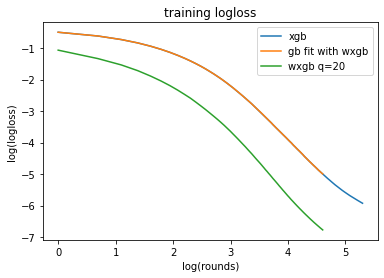

In [43]:
from matplotlib import pyplot as plt
# xgb.XGBClassifier matches GB fit using wxgb exactly
# WB outperforms GB by fitting trees related through beta
# log-log plots to make the relationship clearer
plt.plot(np.log(np.arange(200)+1),np.log(clf.evals_result()['validation_0']['logloss']), label='xgb')
plt.plot(np.log(np.arange(100)+1),np.log(xgb_results['train']['many_logloss']), label='gb fit with wxgb')
plt.plot(np.log(np.arange(100)+1),np.log(wxgb_results['train']['many_logloss']), label='wxgb q=20')
plt.legend()
plt.title('training logloss')
plt.xlabel('log(rounds)')
plt.ylabel('log(logloss)')
plt.show()

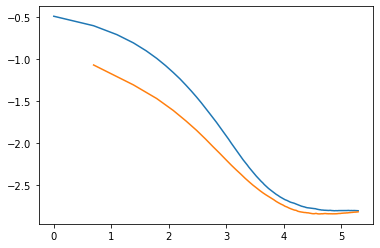

In [31]:
# Controlling for number of trees, wxgb achieves lower test loss
plt.plot(np.log(np.arange(200)+1), np.log(clf.evals_result()['validation_1']['logloss']), label='xgb')
plt.plot(np.log(2*(np.arange(100)+1)),np.log(wxgb_results['test']['many_logloss']), label='wxgb q=20')